# Ensemble Learning

## Initial Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier

## Read the CSV and Perform Basic Data Cleaning

In [4]:
# Load the data
file_path = Path('Resources/credit_y_n_set2.csv')
df = pd.read_csv(file_path)

# Preview the data
df.head()

,member_id,loan,loan_amount,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,...,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status
0,70694,5000,500000,5000,350.0,36 months,BAT5869156,11.54,C,C5,...,NaN,NaN,INDIVIDUAL,NaN,35th week,0,NaN,NaN,NaN,0
1,92502,5000,500000,5000,250.0,36 months,NaN,7.43,A,A2,...,NaN,NaN,INDIVIDUAL,NaN,157th week,0,NaN,NaN,NaN,1
2,95191,20000,2000000,20000,700.0,36 months,NaN,15.01,F,F1,...,NaN,NaN,INDIVIDUAL,NaN,48th week,0,NaN,NaN,NaN,0
3,110482,3500,350000,3500,2575.0,36 months,,12.17,D,D2,...,NaN,NaN,INDIVIDUAL,NaN,157th week,0,NaN,NaN,NaN,1
4,118364,16225,1622500,16225,475.0,36 months,BAT4347689,17.86,G,G5,...,NaN,NaN,INDIVIDUAL,NaN,157th week,1,NaN,NaN,NaN,1


In [5]:
# Cleaning 

df.isnull().sum()

member_id                         0
loan                              0
loan_amount                       0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
batch_enrolled                  388
int_rate                          0
grade                             0
sub_grade                         0
emp_title                       147
emp_length                       58
home_ownership                    0
annual_inc                        0
verification_status               0
pymnt_plan                        0
desc                            771
purpose                           0
title                             2
zip_code                          0
addr_state                        0
dti                               0
delinq_2yrs                       0
inq_last_6mths                    0
mths_since_last_delinq         1498
mths_since_last_record         2175
open_acc                          0
pub_rec                     

<AxesSubplot:>

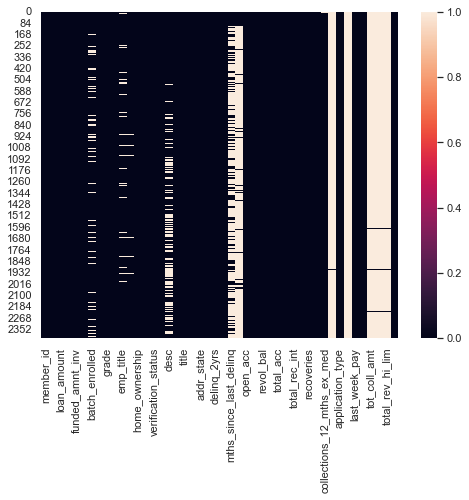

In [6]:
sns.set(rc={'figure.figsize':(8,6)})
sns.heatmap(df.isnull())

In [7]:
df_clean = df.copy()

In [8]:
null_columns = ['batch_enrolled','emp_title', 'emp_length', 'desc', 'title', 'mths_since_last_delinq','mths_since_last_record', 'revol_util',
                'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']
df_clean.drop(null_columns, inplace=True, axis=1)

In [9]:
df_clean

,member_id,loan,loan_amount,funded_amnt,funded_amnt_inv,term,int_rate,grade,sub_grade,home_ownership,...,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,application_type,last_week_pay,acc_now_delinq,loan_status
0,70694,5000,500000,5000,350.0,36 months,11.54,C,C5,MORTGAGE,...,13,f,352.34,0.0,182.27,1.84,INDIVIDUAL,35th week,0,0
1,92502,5000,500000,5000,250.0,36 months,7.43,A,A2,OWN,...,19,f,593.54,0.0,0.00,0.00,INDIVIDUAL,157th week,0,1
2,95191,20000,2000000,20000,700.0,36 months,15.01,F,F1,OWN,...,6,f,2435.47,0.0,667.24,6.68,INDIVIDUAL,48th week,0,0
3,110482,3500,350000,3500,2575.0,36 months,12.17,D,D2,RENT,...,4,f,695.03,0.0,0.00,0.00,INDIVIDUAL,157th week,0,1
4,118364,16225,1622500,16225,475.0,36 months,17.86,G,G5,MORTGAGE,...,20,f,4848.88,0.0,0.00,0.00,INDIVIDUAL,157th week,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2409,1046542,18000,1800000,18000,18000.0,60 months,15.99,D,D2,RENT,...,29,f,8029.91,0.0,0.00,0.00,INDIVIDUAL,226th week,0,0
2410,1046606,25000,2500000,25000,24700.0,60 months,15.99,D,D2,RENT,...,11,f,11227.04,0.0,0.00,0.00,INDIVIDUAL,231th week,0,0
2411,1046615,8400,840000,8400,8400.0,36 months,11.49,B,B4,RENT,...,11,f,1565.02,0.0,0.00,0.00,INDIVIDUAL,157th week,0,1
2412,1047025,4000,400000,4000,4000.0,36 months,5.99,A,A2,RENT,...,18,f,95.45,0.0,0.00,0.00,INDIVIDUAL,22th week,0,1


In [10]:
## getting numeric columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = df_clean.select_dtypes(include=numerics).columns
num
df_clean[num].head(3)

,member_id,loan,loan_amount,funded_amnt,funded_amnt_inv,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,acc_now_delinq,loan_status
0,70694,5000,500000,5000,350.0,11.54,55000.0,10.00,0,4,6,0,2447,13,352.34,0.0,182.27,1.84,0,0
1,92502,5000,500000,5000,250.0,7.43,85000.0,0.31,0,0,7,0,216,19,593.54,0.0,0.00,0.00,0,1
2,95191,20000,2000000,20000,700.0,15.01,80000.0,3.11,1,6,5,0,7883,6,2435.47,0.0,667.24,6.68,0,0


In [11]:
## getting categorical columns
cat = df_clean.drop(num,axis=1)
cat = cat.columns
df_clean[cat].head(3)

,term,grade,sub_grade,home_ownership,verification_status,pymnt_plan,purpose,zip_code,addr_state,initial_list_status,application_type,last_week_pay
0,36 months,C,C5,MORTGAGE,Not Verified,n,other,287xx,NC,f,INDIVIDUAL,35th week
1,36 months,A,A2,OWN,Not Verified,n,credit_card,537xx,WI,f,INDIVIDUAL,157th week
2,36 months,F,F1,OWN,Not Verified,n,credit_card,333xx,FL,f,INDIVIDUAL,48th week


In [12]:
df_clean.corr()

,member_id,loan,loan_amount,funded_amnt,funded_amnt_inv,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,acc_now_delinq,loan_status
member_id,1.000000,0.110424,0.110424,0.110821,0.280674,0.014004,0.013144,0.068410,-0.023942,-0.209187,0.034204,-0.033624,-0.055076,0.061665,0.159336,-0.094982,0.017169,-0.013945,-0.056849,-0.074892
loan,0.110424,1.000000,1.000000,0.980086,0.913507,0.271344,0.311589,0.072588,-0.014643,-0.041757,0.183522,-0.018902,0.260171,0.252244,0.698536,0.032027,0.115409,0.066524,0.015880,-0.126921
loan_amount,0.110424,1.000000,1.000000,0.980086,0.913507,0.271344,0.311589,0.072588,-0.014643,-0.041757,0.183522,-0.018902,0.260171,0.252244,0.698536,0.032027,0.115409,0.066524,0.015880,-0.126921
funded_amnt,0.110821,0.980086,0.980086,1.000000,0.931654,0.275857,0.312008,0.071150,-0.013592,-0.040907,0.174512,-0.021536,0.255548,0.236645,0.700894,0.036484,0.118513,0.069710,0.017406,-0.122783
funded_amnt_inv,0.280674,0.913507,0.913507,0.931654,1.000000,0.263033,0.295785,0.077637,-0.027579,-0.087884,0.155806,-0.029232,0.207110,0.226952,0.684940,-0.007902,0.092350,0.047204,-0.028659,-0.092950
int_rate,0.014004,0.271344,0.271344,0.275857,0.263033,1.000000,0.068087,0.106725,0.170373,0.179780,0.016725,0.122628,0.054111,-0.040625,0.511407,0.067418,0.111547,0.057986,0.032420,-0.228974
annual_inc,0.013144,0.311589,0.311589,0.312008,0.295785,0.068087,1.000000,-0.151943,0.006511,0.009654,0.187541,-0.004419,0.280483,0.267173,0.226891,0.004370,0.001940,-0.004222,0.016351,0.022438
dti,0.068410,0.072588,0.072588,0.071150,0.077637,0.106725,-0.151943,1.000000,-0.010906,-0.001984,0.292671,-0.001355,0.184564,0.228875,0.094713,-0.021718,-0.005662,-0.018023,0.001674,-0.046470
delinq_2yrs,-0.023942,-0.014643,-0.014643,-0.013592,-0.027579,0.170373,0.006511,-0.010906,1.000000,-0.003876,0.017354,0.005944,-0.045800,0.054701,0.031463,0.065780,0.031310,0.022787,0.034098,-0.006626
inq_last_6mths,-0.209187,-0.041757,-0.041757,-0.040907,-0.087884,0.179780,0.009654,-0.001984,-0.003876,1.000000,0.087251,0.076561,-0.000484,0.068498,-0.032920,0.036885,0.062572,0.053205,-0.014460,-0.075137


<AxesSubplot:>

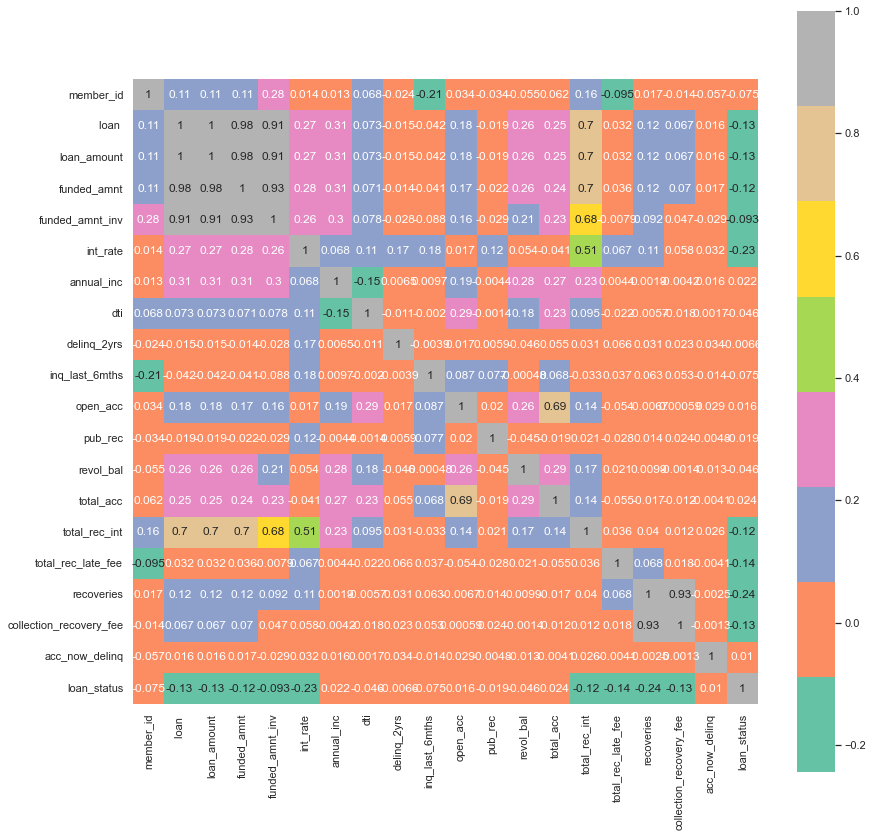

In [13]:
plt.figure(figsize=(14,14))
sns.heatmap(df[num].corr(),annot=True,square=True,cmap='Set2')

In [14]:
df_clean[num].isnull().sum()

member_id                  0
loan                       0
loan_amount                0
funded_amnt                0
funded_amnt_inv            0
int_rate                   0
annual_inc                 0
dti                        0
delinq_2yrs                0
inq_last_6mths             0
open_acc                   0
pub_rec                    0
revol_bal                  0
total_acc                  0
total_rec_int              0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
acc_now_delinq             0
loan_status                0
dtype: int64

## Testing code

In [15]:
# Create our features
X = pd.get_dummies(df_clean.drop('loan_status', axis = 1))

# Create our target 
y = df['loan_status']

## Split the Data into Training and Testing

In [16]:
# Check the balance of our target values
y.value_counts()

1    1942
0     472
Name: loan_status, dtype: int64

In [17]:
X.describe()

,member_id,loan,loan_amount,funded_amnt,funded_amnt_inv,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,last_week_pay_82th week,last_week_pay_83th week,last_week_pay_87th week,last_week_pay_8th week,last_week_pay_91th week,last_week_pay_92th week,last_week_pay_95th week,last_week_pay_96th week,last_week_pay_9th week,last_week_pay_NAth week
count,2.414000e+03,2414.000000,2.414000e+03,2414.000000,2414.000000,2414.000000,2.414000e+03,2414.000000,2414.000000,2414.000000,...,2414.000000,2414.000000,2414.00000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000
mean,7.216943e+05,10839.819801,1.083982e+06,10554.370340,9759.480316,12.159006,7.014700e+04,13.541848,0.149959,1.215824,...,0.002900,0.010356,0.01657,0.001657,0.013256,0.004143,0.001243,0.017813,0.007457,0.003314
std,2.160963e+05,6904.956843,6.904957e+05,6633.602451,6596.425524,3.580595,6.208022e+04,6.666828,0.507595,1.712023,...,0.053782,0.101258,0.12768,0.040681,0.114393,0.064242,0.035238,0.132298,0.086046,0.057484
min,7.069400e+04,500.000000,5.000000e+04,500.000000,0.000000,5.320000,6.000000e+03,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.928735e+05,5500.000000,5.500000e+05,5425.000000,4875.000000,9.630000,4.145900e+04,8.512500,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.513805e+05,9600.000000,9.600000e+05,9500.000000,8375.000000,12.065000,5.800000e+04,13.625000,0.000000,1.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.003872e+05,15000.000000,1.500000e+06,14856.250000,13800.000000,14.720000,8.285500e+04,18.760000,0.000000,2.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.047261e+06,35000.000000,3.500000e+06,35000.000000,35000.000000,25.570000,1.362000e+06,39.540000,10.000000,28.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
# Split the X and y into X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
X_train.shape

(1810, 758)

# Data Pre-Processing
## Standardizing X


In [19]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [20]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [21]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [22]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Ensemble Learners

### Balanced Random Forest Classifier

In [23]:
# Resample the training data with the BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf.fit(X_train_scaled, y_train)

BalancedRandomForestClassifier(random_state=1)

In [24]:
y_pred_brf = brf.predict(X_test_scaled)

In [25]:
# Calculated the balanced accuracy score
bas_brf=balanced_accuracy_score(y_test, y_pred_brf)
print('Easy Ensemble Classifier Balance Accuracy Score: ', bas_brf)
print('AUC-ROC Score :',roc_auc_score(y_test, y_pred_brf))

Easy Ensemble Classifier Balance Accuracy Score:  0.7843964700307984
AUC-ROC Score : 0.7843964700307984


In [26]:
# Display the confusion matrix
cm_brf = confusion_matrix(y_test, y_pred_brf)
cm_df_brf = pd.DataFrame(
                        cm_brf,
                        index=["Actual Approve", "Actual Deny"],
                        columns=["Predicted Approve", "Predicted Deny"]
)
cm_df_brf

,Predicted Approve,Predicted Deny
Actual Approve,141,48
Actual Deny,95,441


In [27]:
# List the features sorted in descending order by feature importance
importances = brf.feature_importances_
importances_sorted = sorted(zip(brf.feature_importances_, X.columns), reverse=True)
importances_sorted[:10]

[(0.10863596676869237, 'recoveries'),
 (0.10642751016251384, 'collection_recovery_fee'),
 (0.038298507755025746, 'int_rate'),
 (0.030388771554826822, 'total_rec_int'),
 (0.02939077871740297, 'revol_bal'),
 (0.027456379945041916, 'last_week_pay_157th week'),
 (0.026343486945302724, 'annual_inc'),
 (0.025672286406972833, 'funded_amnt_inv'),
 (0.025415521897678123, 'member_id'),
 (0.024588926511930488, 'dti')]

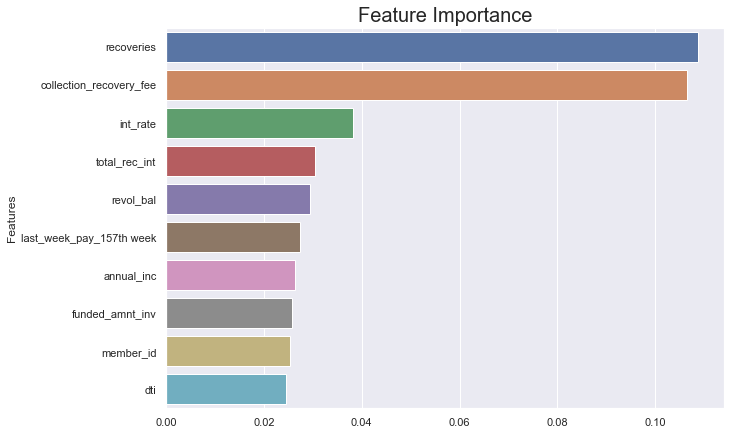

In [28]:
# List the features sorted in descending order by feature importance
importances = brf.feature_importances_
feature_importances=pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,7))
sns.barplot(x=feature_importances[0:10], y=feature_importances.index[0:10])
plt.title('Feature Importance',size=20)
plt.ylabel("Features")
plt.show()

In [29]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_brf))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.60      0.75      0.82      0.66      0.78      0.61       189
          1       0.90      0.82      0.75      0.86      0.78      0.62       536

avg / total       0.82      0.80      0.77      0.81      0.78      0.62       725



In [30]:
print('Cross Validation:',cross_val_score(brf, X_test_scaled, y_pred_brf, cv=5).mean())
# The purpose of cross–validation is to test the ability of a machine learning model to predict new data.
# It is also used to flag problems like overfitting or selection bias and gives insights on how the model will
# generalize to an independent dataset.

Cross Validation: 0.8951724137931034


In [31]:
brf_val = pd.Series(y_test).value_counts()
brf_valpred = pd.Series(y_pred_brf).value_counts()
brf_x1 = brf_val[1]
brf_x2 = brf_val[0]
brf_x3 = brf_valpred[1]
brf_x4 = brf_valpred[0]

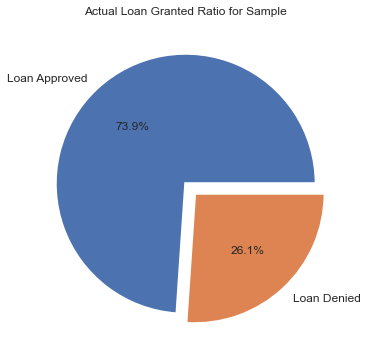

In [32]:
# Pie Plot of Actual Loan Approved
explode = (0, 0.1)
labels = ['Loan Approved', 'Loan Denied']

plt.pie([brf_x1, brf_x2], explode=explode, startangle=0, labels=labels, autopct='%.1f%%', wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, textprops={'size': 'medium'}, radius=1)
plt.title('Actual Loan Granted Ratio for Sample')
plt.savefig('Actual_pie_actu.png')
plt.show()

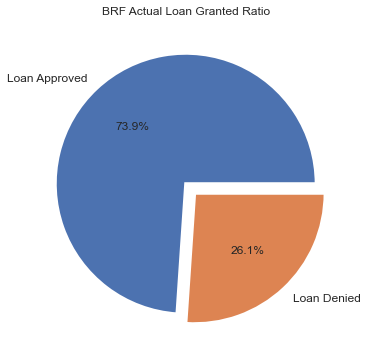

In [33]:
# Pie Plot of Actual Loan Approved
explode = (0, 0.1)
labels = ['Loan Approved', 'Loan Denied']

plt.pie([brf_x1, brf_x2], explode=explode, startangle=0, labels=labels, autopct='%.1f%%', wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, textprops={'size': 'medium'}, radius=1)
plt.title('BRF Actual Loan Granted Ratio')
#plt.savefig('BRF_pie_actu.png')
plt.show()

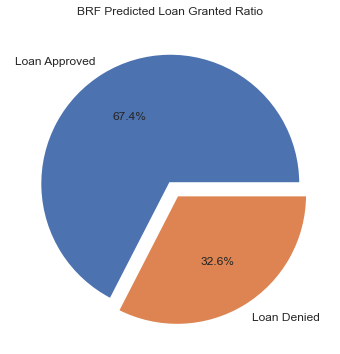

In [34]:
# Pie Plot of Actual Loan Approved
explode = (0, 0.1)
labels = ['Loan Approved', 'Loan Denied']

plt.pie([brf_x3, brf_x4], explode=explode, startangle=0, labels=labels, autopct='%.1f%%', wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, textprops={'size': 'medium'}, radius=1)
plt.title('BRF Predicted Loan Granted Ratio')
plt.savefig('BRF_pie_pred.png')
plt.show()

### Easy Ensemble Classifier

In [35]:
# Train the Classifier
eec = EasyEnsembleClassifier(n_estimators=100, random_state=1)
eec.fit(X_train_scaled, y_train)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [36]:
y_pred_eec = eec.predict(X_test_scaled)

In [37]:
# Calculated the balanced accuracy score
bas_eec=balanced_accuracy_score(y_test, y_pred_brf)
print('Easy Ensemble Classifier Balance Accuracy Score: ', bas_eec)
print('AUC-ROC Score :',roc_auc_score(y_test, y_pred_eec))

Easy Ensemble Classifier Balance Accuracy Score:  0.7843964700307984
AUC-ROC Score : 0.7688442707099424


In [38]:
# Display the confusion matrix
cm_eec = confusion_matrix(y_test, y_pred_eec)
cm_df_eec = pd.DataFrame(
                        cm_eec,
                        index=["Actual Approve", "Actual Deny"],
                        columns=["Predicted Approve", "Predicted Deny"]
)
cm_df_eec

,Predicted Approve,Predicted Deny
Actual Approve,139,50
Actual Deny,106,430


In [39]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_eec))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.57      0.74      0.80      0.64      0.77      0.59       189
          1       0.90      0.80      0.74      0.85      0.77      0.59       536

avg / total       0.81      0.78      0.75      0.79      0.77      0.59       725



In [40]:
print('Cross Validation:',cross_val_score(eec, X_test_scaled, y_pred_eec, cv=5).mean())
# The purpose of cross–validation is to test the ability of a machine learning model to predict new data.
# It is also used to flag problems like overfitting or selection bias and gives insights on how the model will
# generalize to an independent dataset.

Cross Validation: 0.8758620689655172


In [41]:
eec_val = pd.Series(y_test).value_counts()
eec_valpred = pd.Series(y_pred_eec).value_counts()
eec_x1 = eec_val[1]
eec_x2 = eec_val[0]
eec_x3 = eec_valpred[1]
eec_x4 = eec_valpred[0]

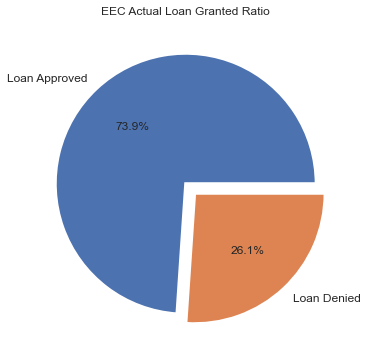

In [42]:
# Pie Plot of Actual Loan Approved
explode = (0, 0.1)
labels = ['Loan Approved', 'Loan Denied']

plt.pie([eec_x1, eec_x2], explode=explode, startangle=0, labels=labels, autopct='%.1f%%', wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, textprops={'size': 'medium'}, radius=1)
plt.title('EEC Actual Loan Granted Ratio')
#plt.savefig('EEC_pie_actu.png')
plt.show()

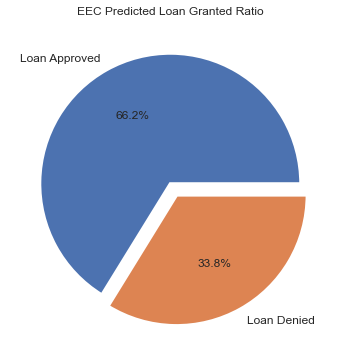

In [43]:
# Pie Plot of Actual Loan Approved
explode = (0, 0.1)
labels = ['Loan Approved', 'Loan Denied']

plt.pie([eec_x3, eec_x4], explode=explode, startangle=0, labels=labels, autopct='%.1f%%', wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, textprops={'size': 'medium'}, radius=1)
plt.title('EEC Predicted Loan Granted Ratio')
plt.savefig('EEC_pie_pred.png')
plt.show()

### Interesting Insights

1. Which model had the best balanced accuracy score?

    Both models are the same bas value of 0.7843964700307984.

2. Which model had the best recall score?

    Balanced Random Forest has better recall overall (0.80) when compared to Easy Ensemble Classifier (0.78)

3. Which model had the best geometric mean score?

    Balanced Random Forest had better geometric mean score of 0.78, opposed to 0.77 by Easy Ensemble
    
4. What are the top three features?

    1. recoveries at 0.10863596676869237,
    2. collection_recovery_fee at 0.10642751016251384,
    3. int_rate at 0.038298507755025746.

# XGBoost

In [44]:
# pip install xgboost

In [45]:
# Not gone into depth in class. Below are the initialisations

from xgboost import XGBClassifier
#from plotly.subplots import make_subplots
#import plotly.graph_objects as go

In [46]:
xgb_model = XGBClassifier(n_estimators=50,max_depth=4)

In [47]:
xgb_model.fit(X_train_scaled, y_train)

[19:21:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [48]:
y_pred_xgb=xgb_model.predict(X_test_scaled)

In [49]:
bas_xgb=balanced_accuracy_score(y_test, y_pred_xgb)
print('XGB Balance Accuracy Score: ', bas_xgb)
print('AUC-ROC Score :',roc_auc_score(y_test, y_pred_xgb))

XGB Balance Accuracy Score:  0.7264421937929401
AUC-ROC Score : 0.7264421937929401


In [50]:
# Display the confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_df_xgb = pd.DataFrame(
                        cm_xgb,
                        index=["Actual Approve", "Actual Deny"],
                        columns=["Predicted Approve", "Predicted Deny"]
)
cm_df_xgb

,Predicted Approve,Predicted Deny
Actual Approve,93,96
Actual Deny,21,515


In [51]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_xgb))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.82      0.49      0.96      0.61      0.69      0.45       189
          1       0.84      0.96      0.49      0.90      0.69      0.49       536

avg / total       0.84      0.84      0.61      0.82      0.69      0.48       725



In [52]:
print('Cross Validation:',cross_val_score(xgb_model, X_test_scaled, y_pred_xgb, cv=5).mean())
# The purpose of cross–validation is to test the ability of a machine learning model to predict new data.
# It is also used to flag problems like overfitting or selection bias and gives insights on how the model will
# generalize to an independent dataset.

[19:21:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

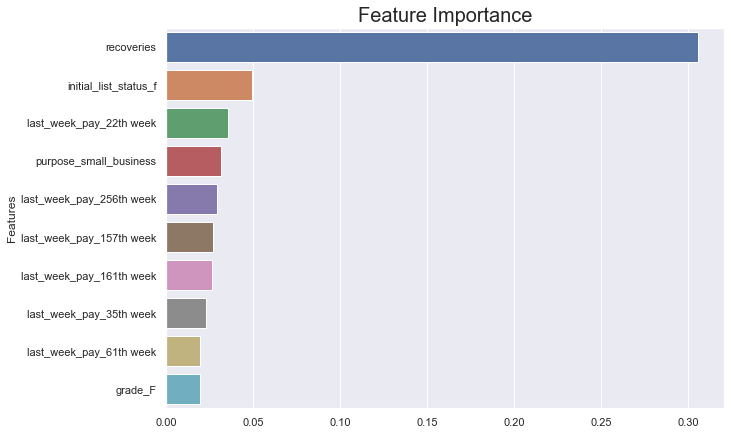

In [56]:
# List the features sorted in descending order by feature importance
importances = xgb_model.feature_importances_
feature_importances=pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,7))
sns.barplot(x=feature_importances[0:10], y=feature_importances.index[0:10])
plt.title('Feature Importance',size=20)
plt.ylabel("Features")
plt.show()

In [54]:
xgb_val = pd.Series(y_test).value_counts()
xgb_valpred = pd.Series(y_pred_xgb).value_counts()
xgb_x1 = xgb_val[1]
xgb_x2 = xgb_val[0]
xgb_x3 = xgb_valpred[1]
xgb_x4 = xgb_valpred[0]

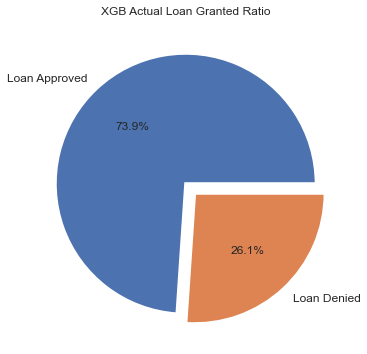

In [55]:
# Pie Plot of Actual Loan Approved
explode = (0, 0.1)
labels = ['Loan Approved', 'Loan Denied']

plt.pie([xgb_x1, xgb_x2], explode=explode, startangle=0, labels=labels, autopct='%.1f%%', wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, textprops={'size': 'medium'}, radius=1)
plt.title('XGB Actual Loan Granted Ratio')
#plt.savefig('XGB_pie_actu.png')
plt.show()

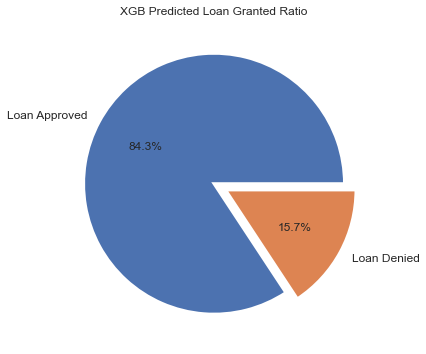

In [56]:
# Pie Plot of Actual Loan Approved
explode = (0, 0.1)
labels = ['Loan Approved', 'Loan Denied']

plt.pie([xgb_x3, xgb_x4], explode=explode, startangle=0, labels=labels, autopct='%.1f%%', wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, textprops={'size': 'medium'}, radius=1)
plt.title('XGB Predicted Loan Granted Ratio')
plt.savefig('XGB_pie_pred.png')
plt.show()